## 1. GNN Visualization for Binder Prediction Model

In [1]:
import torch
from torch_geometric.data import Data
import deepchem as dc
from rdkit import Chem

smiles = "C1=CC=C(C(=C1)C(=O)C2=CN(N=N2)C3=CC=CC(=C3)C(=O)O)N"
mol = Chem.MolFromSmiles(smiles)
featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True, use_chirality=True)
f = featurizer._featurize(mol)
node_features = torch.tensor(f.node_features)
edge_index = torch.tensor(f.edge_index)
edge_attr = torch.tensor(f.edge_features)
data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)
data.smiles = smiles
data

/home/lxiong/anaconda3/envs/try37/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


Data(x=[23, 32], edge_index=[2, 50], edge_attr=[50, 11], smiles='C1=CC=C(C(=C1)C(=O)C2=CN(N=N2)C3=CC=CC(=C3)C(=O)O)N')

In [ ]:
import torch
from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.data import Batch

from model import GraphTransformerModel
import json
import random 
import numpy as np
import os

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
set_seed(0)

def explain_graph_model(model, data_graph):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    data_graph = data_graph.to(device)

    explainer = Explainer(
        model=model,
        algorithm=GNNExplainer(epochs=200),  
        explanation_type='model',     
        node_mask_type='object',  
        edge_mask_type='object',      
        
        model_config=dict(
            mode='binary_classification',  
            task_level='graph',            
            return_type='raw',             
        ),
    )

    x, edge_index, edge_attr , batch_index = data_graph.x.float(), data_graph.edge_index.long(), data_graph.edge_attr.float(), data_graph.batch.long()

    explanation = explainer(x=x, edge_index=edge_index, edge_attr=edge_attr, batch_index=batch_index)  

    return explanation

with open('best_hyperparameters.json', 'r') as f:
    all_params = json.load(f)

params = all_params['binder_ros_GT']

model = GraphTransformerModel(
    in_channels=32,
    hidden_channels=params['hidden_channels'],
    out_channels=1,  
    edge_dim=11,
    num_layers=params['num_layers'],
    n_heads=params['n_heads'],
    dropout=params['dropout']
)

def load_model_weights(model):
    model_path = f'graph_models/binder/ros/GT.pth'
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

model = load_model_weights(model)
data_graph = [data] 
data_graph = Batch.from_data_list(data_graph)

explanation = explain_graph_model(model, data_graph)

In [3]:
selected_smiles = [data_graph.smiles]
atom_weights_list = explanation.node_mask.flatten().tolist()
atom_weights_list = [atom_weights_list]
atom_weights = np.array(atom_weights_list[0], dtype=float)

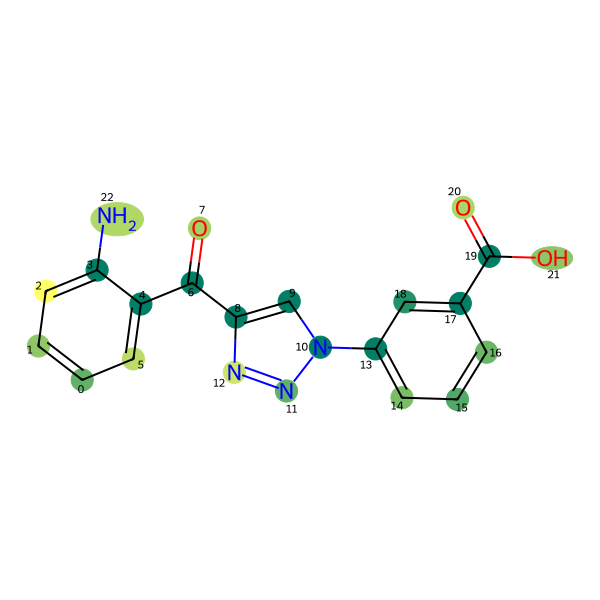

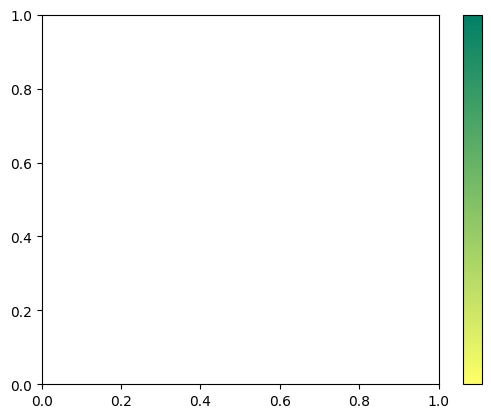

In [4]:
from rdkit import Chem
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm, colors
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG


for i, smiles in enumerate(selected_smiles):
    mol = Chem.MolFromSmiles(smiles[0])

    atom_weights = np.array(atom_weights_list[i], dtype=float)

    if len(atom_weights) != mol.GetNumAtoms():
        print(f"Warning: The number of weights does not match the number of atoms in molecule {smiles}")
        continue

    min_value = atom_weights.min()
    max_value = atom_weights.max()
    atom_weights = (atom_weights - min_value) / (max_value - min_value)

    c = atom_weights.flatten().tolist()
    norm = colors.Normalize(vmin=0, vmax=sum(c) / len(c)) 

    cmap = cm.get_cmap('summer_r')
    plt_colors = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

    atom_colors = {i: plt_colors.to_rgba(atom_weights[i]) for i in range(len(atom_weights))} 

    plt_colors._A = []
    cb = plt.colorbar(plt_colors)
    cb.set_ticks([])

    rdDepictor.Compute2DCoords(mol)

    drawer = rdMolDraw2D.MolDraw2DSVG(600, 600) 
    drawer.SetFontSize(6.0)
    drawer.drawOptions().addAtomIndices = True  

    mol = rdMolDraw2D.PrepareMolForDrawing(mol)

    drawer.DrawMolecule(
        mol,
        highlightAtoms=range(len(atom_weights)),
        highlightAtomColors=atom_colors,
        highlightBonds=[]
    )
    drawer.FinishDrawing()

    svg = drawer.GetDrawingText().replace('svg:', '')

    display(SVG(svg))

## 2.GNN Visualization for Antagonist Prediction Model

In [5]:
import torch
from torch_geometric.data import Data
import deepchem as dc
from rdkit import Chem

smiles = "COc1cc(/C=C(\C#N)C(=O)Nc2nnc(C(F)(F)F)s2)ccc1OCc1ccc(C(F)(F)F)cc1C(F)(F)F"
mol = Chem.MolFromSmiles(smiles)
featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True, use_chirality=True)
f = featurizer._featurize(mol)
node_features = torch.tensor(f.node_features)
edge_index = torch.tensor(f.edge_index)
edge_attr = torch.tensor(f.edge_features)
data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)
data.smiles = smiles

data

Data(x=[40, 32], edge_index=[2, 84], edge_attr=[84, 11], smiles='COc1cc(/C=C(\C#N)C(=O)Nc2nnc(C(F)(F)F)s2)ccc1OCc1ccc(C(F)(F)F)cc1C(F)(F)F')

In [ ]:
import torch
from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.data import Batch

from torch_geometric.nn.models import AttentiveFP
from model import GraphTransformerModel, GINModel, GCNModel, GATModel
import json
import random 
import numpy as np
import os

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

set_seed(0)

def explain_graph_model(model, data_graph):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    data_graph = data_graph.to(device)

    explainer = Explainer(
        model=model,
        algorithm=GNNExplainer(epochs=200),  
        explanation_type='model',     
        node_mask_type='object',  
        edge_mask_type='object',      
        
        model_config=dict(
            mode='binary_classification',  
            task_level='graph',            
            return_type='raw',             #
        ),
    )


    x, edge_index, edge_attr , batch_index = data_graph.x.float(), data_graph.edge_index.long(), data_graph.edge_attr.float(), data_graph.batch.long()

    explanation = explainer(x=x, edge_index=edge_index, edge_attr=edge_attr,batch=batch_index)   

    return explanation

with open('best_hyperparameters.json', 'r') as f:
    all_params = json.load(f)

params = all_params['antagonist_ros_GCN']

model = GCNModel(
    in_channels=32,
    hidden_channels=params['hidden_channels'],
    out_channels=1,  
    edge_dim=11,
    num_layers=params['num_layers'],
    dropout=params['dropout']
)

def load_model_weights(model):
    model_path = f'graph_models/antagonist/ros/GCN.pth'
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

model = load_model_weights(model)

data_graph = [data]  
data_graph = Batch.from_data_list(data_graph)

explanation = explain_graph_model(model, data_graph)

In [7]:
selected_smiles = [data_graph.smiles]
atom_weights_list = explanation.node_mask.flatten().tolist()
atom_weights_list = [atom_weights_list]
atom_weights = np.array(atom_weights_list[0], dtype=float)

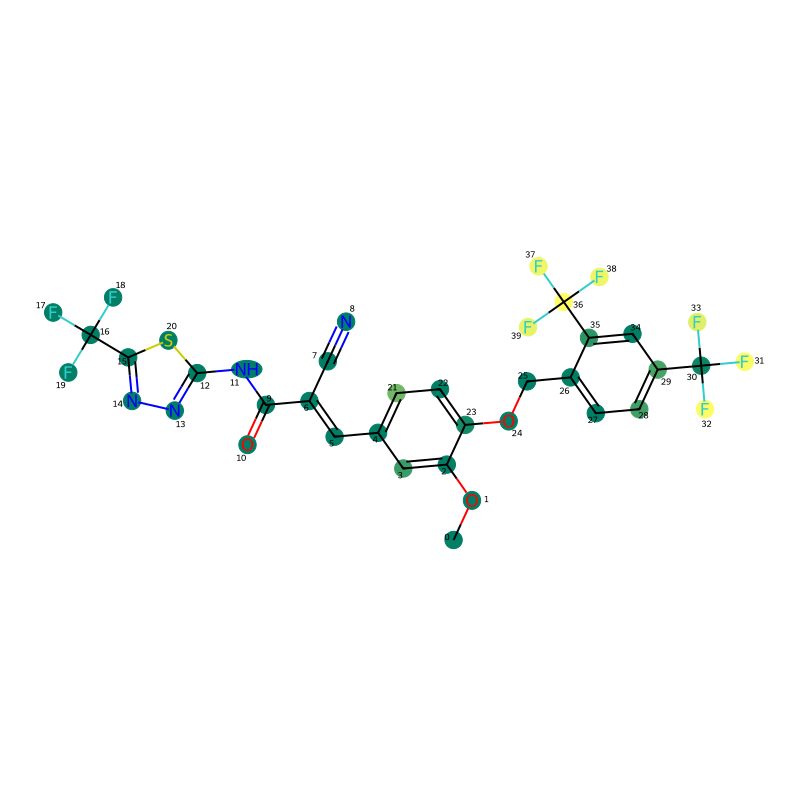

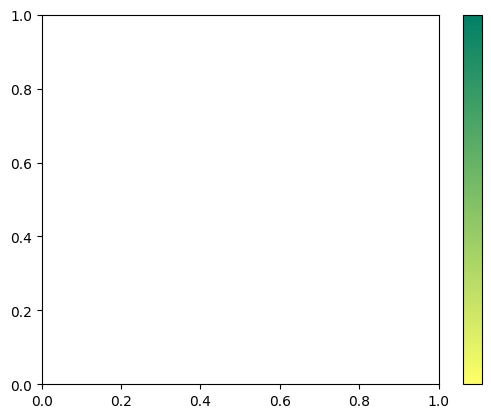

In [8]:
from rdkit import Chem
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm, colors
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG


for i, smiles in enumerate(selected_smiles):
    mol = Chem.MolFromSmiles(smiles[0])

    atom_weights = np.array(atom_weights_list[i], dtype=float)

    if len(atom_weights) != mol.GetNumAtoms():
        print(f"Warning: The number of weights does not match the number of atoms in molecule {smiles}")
        continue

    min_value = atom_weights.min()
    max_value = atom_weights.max()
    atom_weights = (atom_weights - min_value) / (max_value - min_value)

    
    c = atom_weights.flatten().tolist()
    norm = colors.Normalize(vmin=0, vmax=sum(c) / len(c)) 

    cmap = cm.get_cmap('summer_r') 
    plt_colors = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

    atom_colors = {i: plt_colors.to_rgba(atom_weights[i]) for i in range(len(atom_weights))} 

    plt_colors._A = []
    cb = plt.colorbar(plt_colors)
    cb.set_ticks([])

    rdDepictor.Compute2DCoords(mol)

    drawer = rdMolDraw2D.MolDraw2DSVG(800, 800) 
    drawer.SetFontSize(6.0)
    drawer.drawOptions().addAtomIndices = True  

    mol = rdMolDraw2D.PrepareMolForDrawing(mol)

    drawer.DrawMolecule(
        mol,
        highlightAtoms=range(len(atom_weights)),
        highlightAtomColors=atom_colors,
        highlightBonds=[]
    )
    drawer.FinishDrawing()

    svg = drawer.GetDrawingText().replace('svg:', '')
    
    display(SVG(svg)) 

## 3. ## 2.GNN Visualization for Agonist Prediction Model

In [9]:
import torch
from torch_geometric.data import Data
import deepchem as dc
from rdkit import Chem

smiles = "CC(=O)NC1=CC(=C(C=C1)OC2=CC(=C(C=C2)O)C(C)(C)C)Cl"

mol = Chem.MolFromSmiles(smiles)

featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True, use_chirality=True)
f = featurizer._featurize(mol)
node_features = torch.tensor(f.node_features)
edge_index = torch.tensor(f.edge_index)
edge_attr = torch.tensor(f.edge_features)
data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)
data.smiles = smiles

data

Data(x=[23, 32], edge_index=[2, 48], edge_attr=[48, 11], smiles='CC(=O)NC1=CC(=C(C=C1)OC2=CC(=C(C=C2)O)C(C)(C)C)Cl')

In [ ]:
import torch
from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.data import Batch

from torch_geometric.nn.models import AttentiveFP
from model import GraphTransformerModel, GINModel, GCNModel, GATModel
import json
import random 
import numpy as np
import os

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    # torch.use_deterministic_algorithms(True) # 确定性算法
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

set_seed(0)

def explain_graph_model(model, data_graph):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    data_graph = data_graph.to(device)

    explainer = Explainer(
        model=model,
        algorithm=GNNExplainer(epochs=200),  
        explanation_type='model',     
        node_mask_type='object',  
        edge_mask_type=None,      
        
        model_config=dict(
            mode='binary_classification',  
            task_level='graph',            
            return_type='raw',             
        ),
    )

    x, edge_index, edge_attr , batch_index = data_graph.x.float(), data_graph.edge_index.long(), data_graph.edge_attr.float(), data_graph.batch.long()


    explanation = explainer(x=x, edge_index=edge_index, edge_attr=edge_attr, batch=batch_index)   

    return explanation

with open('best_hyperparameters.json', 'r') as f:
    all_params = json.load(f)

params = all_params['agonist_ros_AFP']

model = AttentiveFP(
    in_channels=32,
    hidden_channels=params['hidden_channels'],
    out_channels=1,  
    edge_dim=11,
    num_layers=params['num_layers'],
    num_timesteps=params['num_timesteps'],
    dropout=params['dropout']
)

def load_model_weights(model):
    model_path = f'graph_models/agonist/ros/AFP.pth'
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

model = load_model_weights(model)

data_graph = [data]  
data_graph = Batch.from_data_list(data_graph)

explanation = explain_graph_model(model, data_graph)

In [11]:
selected_smiles = [data_graph.smiles]
atom_weights_list = explanation.node_mask.flatten().tolist()
atom_weights_list = [atom_weights_list]
atom_weights = np.array(atom_weights_list[0], dtype=float)

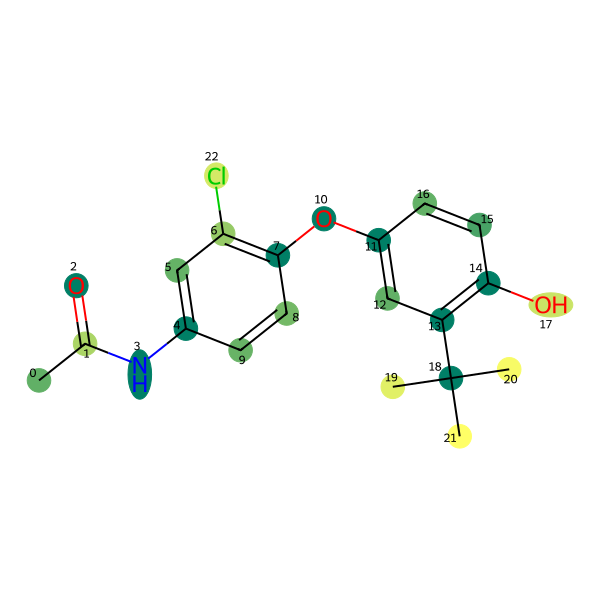

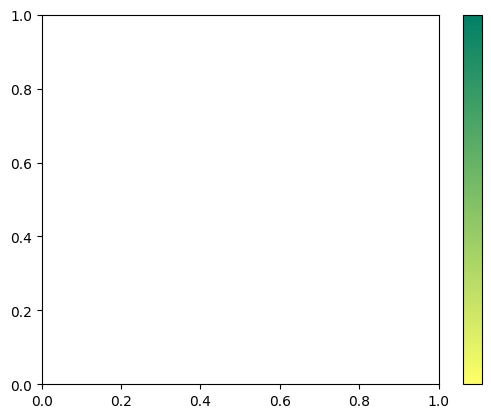

In [ ]:
from rdkit import Chem
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm, colors
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG


for i, smiles in enumerate(selected_smiles):
    mol = Chem.MolFromSmiles(smiles[0])

    atom_weights = np.array(atom_weights_list[i], dtype=float)

    if len(atom_weights) != mol.GetNumAtoms():
        print(f"Warning: The number of weights does not match the number of atoms in molecule {smiles}")
        continue

    min_value = atom_weights.min()
    max_value = atom_weights.max()
    atom_weights = (atom_weights - min_value) / (max_value - min_value)

    c = atom_weights.flatten().tolist()
    norm = colors.Normalize(vmin=0, vmax=sum(c) / len(c)) 

    cmap = cm.get_cmap('summer_r') 
    plt_colors = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

    atom_colors = {i: plt_colors.to_rgba(atom_weights[i]) for i in range(len(atom_weights))} 

    plt_colors._A = []
    cb = plt.colorbar(plt_colors)
    cb.set_ticks([])

    rdDepictor.Compute2DCoords(mol)

    drawer = rdMolDraw2D.MolDraw2DSVG(600, 600) 
    drawer.SetFontSize(6.0)
    drawer.drawOptions().addAtomIndices = True  

    mol = rdMolDraw2D.PrepareMolForDrawing(mol)

    drawer.DrawMolecule(
        mol,
        highlightAtoms=range(len(atom_weights)),
        highlightAtomColors=atom_colors,
        highlightBonds=[]
    )
    drawer.FinishDrawing()


    svg = drawer.GetDrawingText().replace('svg:', '')

    display(SVG(svg)) 